In [ ]:

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import altair as alt
from scipy.ndimage import gaussian_filter
from collections import Counter
import re
from urllib.parse import urlparse
import plotly.express as px
from pydantic import BaseModel
from typing import List
from google import genai
import json
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
df = pd.read_csv('py_final.csv')

In [6]:
df

,ParticipantId,DeviceId,url,eventtimeutc,transition,title,visitId,referringVisitId,eventtime,base_url,category
0,demo,2nwjevbvxzm7ehb254,https://www.avios.com/manage-avios/move-and-co...,2025-01-21T11:00:35.229Z,typed,Convert Avios: Nectar &#44; Finnair Plus &#44...,160209,0,2025-01-21T03:00:35-08:00,www.avios.com,travel_booking
1,demo,2nwjevbvxzm7ehb254,https://www.avios.com/manage-avios/move-and-co...,2025-01-21T11:00:36.207Z,link,Convert Avios: Nectar &#44; Finnair Plus &#44...,160210,0,2025-01-21T03:00:36-08:00,www.avios.com,travel_booking
2,demo,2nwjevbvxzm7ehb254,https://www.avios.com/manage-avios/move-and-co...,2025-01-21T11:00:37.059Z,link,Convert Avios: Nectar &#44; Finnair Plus &#44...,160211,0,2025-01-21T03:00:37-08:00,www.avios.com,travel_booking
3,demo,2nwjevbvxzm7ehb254,https://accounts.britishairways.com/u/login?st...,2025-01-21T11:00:39.407Z,link,British Airways log in,160213,160212,2025-01-21T03:00:39-08:00,accounts.britishairways.com,travel_booking
4,demo,2nwjevbvxzm7ehb254,https://accounts.britishairways.com/security/?...,2025-01-21T11:00:49.624Z,form_submit,British Airways,160218,160217,2025-01-21T03:00:49-08:00,accounts.britishairways.com,travel_booking
...,...,...,...,...,...,...,...,...,...,...,...
5099,demo,2nwjevbvxzm7ehb254,https://py-insights.com/account/demo/product?s...,2025-02-21T07:57:40.972Z,link,PY Insights | Product,166319,0,2025-02-20T23:57:40-08:00,py-insights.com,developer_tools
5100,demo,2nwjevbvxzm7ehb254,https://py-insights.com/account/demo/product,2025-02-21T07:57:40.975Z,link,PY Insights | Product,166320,0,2025-02-20T23:57:40-08:00,py-insights.com,developer_tools
5101,demo,2nwjevbvxzm7ehb254,https://py-insights.com/account/demo/product?s...,2025-02-21T07:57:40.988Z,link,PY Insights | Product,166321,0,2025-02-20T23:57:40-08:00,py-insights.com,developer_tools
5102,demo,2nwjevbvxzm7ehb254,https://chromewebstore.google.com/detail/snaps...,2025-02-21T07:57:51.308Z,link,Snapshot - Chrome Web Store,166327,166326,2025-02-20T23:57:51-08:00,chromewebstore.google.com,marketplace


In [71]:
def plot_daily_visits_interactive(df, top_n=50):
    # Convert datetime columns
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], errors='coerce')
    df['eventtime'] = pd.to_datetime(df['eventtime'], errors='coerce')

    # Drop rows with invalid datetime values
    df = df.dropna(subset=['eventtimeutc', 'eventtime'])

    # Ensure the 'base_url' column exists
    if 'base_url' not in df.columns:
        raise KeyError("The 'base_url' column is missing in the DataFrame.")

    # Get the top N base URLs
    top_base_urls = df['base_url'].value_counts().head(top_n).index.tolist()

    # Aggregate visits by date and base URL, and filter for top URLs
    daily_visits = df.groupby(df['eventtimeutc'].dt.date)['base_url'].value_counts().unstack(fill_value=0).stack().reset_index(name='visits')
    daily_visits = daily_visits.rename(columns={'level_1': 'base_url'})
    daily_visits = daily_visits[daily_visits['base_url'].isin(top_base_urls)]

    # Convert eventtimeutc to string for plotting
    daily_visits['eventtimeutc'] = daily_visits['eventtimeutc'].astype(str)

    # Create the interactive chart
    chart = alt.Chart(daily_visits).mark_line().encode(
        x=alt.X('eventtimeutc', title='Date'),
        y=alt.Y('visits', title='Number of Visits'),
        color=alt.Color('base_url', title='Site'),
        tooltip=['eventtimeutc', 'base_url', 'visits']
    ).properties(
        title=f'Daily Visits for Top {top_n} Sites'
    ).interactive()

    return chart

# Call the function and save the chart
chart = plot_daily_visits_interactive(df)
display(chart)
#export chart as html
chart.save('daily_visits_interactive.html')

c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.



alt.Chart(...)

c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.



In [8]:

def plot_daily_visits_stacked_bar(df, top_n=15):
    # Convert datetime columns
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], errors='coerce')
    df['eventtime'] = pd.to_datetime(df['eventtime'], errors='coerce')

    # Drop rows with invalid datetime values
    df = df.dropna(subset=['eventtimeutc', 'eventtime'])

    # Ensure the 'base_url' column exists
    if 'base_url' not in df.columns:
        raise KeyError("The 'base_url' column is missing in the DataFrame.")

    # Get the top N base URLs
    top_base_urls = df['base_url'].value_counts().head(top_n).index.tolist()

    # Aggregate visits by date and base URL, and filter for top URLs
    daily_visits = (
        df[df['base_url'].isin(top_base_urls)]
        .groupby([df['eventtimeutc'].dt.date, 'base_url'])
        .size()
        .reset_index(name='visits')
    )

    # Convert date to string for better axis labeling
    daily_visits['eventtimeutc'] = daily_visits['eventtimeutc'].astype(str)
    # Save chart for powerbi as csv
    daily_visits.to_csv('daily_visits.csv', index=False)

    # Create the stacked bar chart
    chart = alt.Chart(daily_visits).mark_bar().encode(
        x=alt.X('eventtimeutc:N', title='Date'),
        y=alt.Y('visits:Q', title='Number of Visits'),
        color=alt.Color('base_url:N', title='Site'),
        tooltip=['eventtimeutc', 'base_url', 'visits']
    ).properties(
        title=f'Stacked Daily Visits for Top {top_n} Sites',
        width=800,
        height=400
    ).interactive()

    return chart

# Call the function
chart = plot_daily_visits_stacked_bar(df)
display(chart)




c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\ProgramData\anaconda3\Lib\site-packages\altair\utils\core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [9]:
def analyze_and_plot_browsing_data_plotly(df):
    # Convert eventtimeutc to datetime
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], utc=True)

    # Sort by eventtimeutc (ascending) to ensure chronological order
    df = df.sort_values(by=['eventtimeutc'])

    # Check for duplicates
    print(f"Duplicates: {df.duplicated().sum()}")

    # Calculate time difference between consecutive events
    df['time_diff'] = df['eventtimeutc'].diff().fillna(pd.Timedelta(0))

    # Identify session ends when the time difference exceeds 5 minutes
    df['session_end'] = df['time_diff'] > pd.Timedelta(minutes=5)

    # Create session ID based on cumulative session end
    df['session_id'] = df['session_end'].cumsum()

    # Group by session_id to get session start and end times
    sessions = df.groupby('session_id')['eventtimeutc'].agg(['min', 'max']).reset_index()
    sessions.columns = ['session_id', 'session_start', 'session_end']

    # Calculate session duration
    sessions['duration'] = sessions['session_end'] - sessions['session_start']

    # Prepare to collect daily active time
    daily_active_time = {}

    # Iterate over each session to split its duration into days
    for _, session in sessions.iterrows():
        start = session['session_start']
        end = session['session_end']
        duration = session['duration']

        if duration.total_seconds() == 0:
            # Session with single event, no active time
            continue

        # Determine all dates the session spans
        current_date = start.date()
        end_date = end.date()

        # Iterate through each date from start to end
        while current_date <= end_date:
            # Calculate the start and end of the current date
            date_start = pd.Timestamp(current_date).tz_localize('UTC')
            date_end = date_start + pd.Timedelta(days=1)

            # Calculate overlap between session and current date
            overlap_start = max(start, date_start)
            overlap_end = min(end, date_end)
            overlap_duration = max(pd.Timedelta(0), overlap_end - overlap_start)

            # Convert duration to hours
            overlap_hours = overlap_duration.total_seconds() / 3600

            # Add to daily active time
            if current_date in daily_active_time:
                daily_active_time[current_date] += overlap_hours
            else:
                daily_active_time[current_date] = overlap_hours

            # Move to next date
            current_date += pd.Timedelta(days=1).to_pytimedelta()

    # Convert daily_active_time to DataFrame
    dates = sorted(daily_active_time.keys())
    hours = [min(daily_active_time[date], 24) for date in dates]  # Ensure max 24 hours
    daily_active_time_df = pd.DataFrame({'date': dates, 'active_time_hours': hours})

    # Plotting
    fig = px.line(daily_active_time_df,
                  x='date',
                  y='active_time_hours',
                  title='Daily Active Time (Hours)',
                  labels={'date': 'Date', 'active_time_hours': 'Active Time (Hours)'})
    fig.update_layout(title_x=0.5, xaxis_tickangle=-45)
    fig.show()

# Example usage
analyze_and_plot_browsing_data_plotly(df)

Duplicates: 0


In [10]:


def analyze_and_plot_browsing_data_plotly(df):
    # Convert eventtimeutc to datetime
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], utc=True)
    df = df.sort_values(by=['eventtimeutc'])  # Ensure chronological order

    # Calculate time difference between consecutive events
    df['time_diff'] = df['eventtimeutc'].diff().fillna(pd.Timedelta(0))

    # Identify session ends when time difference exceeds 5 minutes
    df['session_end'] = df['time_diff'] > pd.Timedelta(minutes=5)
    df['session_id'] = df['session_end'].cumsum()

    # Group by session_id to get session start and end times
    sessions = df.groupby('session_id')['eventtimeutc'].agg(['min', 'max']).reset_index()
    sessions.columns = ['session_id', 'session_start', 'session_end']

    # Calculate session duration
    sessions['duration'] = sessions['session_end'] - sessions['session_start']

    # Prepare to collect daily active time
    daily_active_time = {}

    # Iterate over each session to split its duration into days
    for _, session in sessions.iterrows():
        start = session['session_start']
        end = session['session_end']
        duration = session['duration']

        if duration.total_seconds() == 0:
            continue  # Skip single-event sessions

        current_date = start.date()
        end_date = end.date()

        while current_date <= end_date:
            date_start = pd.Timestamp(current_date).tz_localize('UTC')
            date_end = date_start + pd.Timedelta(days=1)

            overlap_start = max(start, date_start)
            overlap_end = min(end, date_end)
            overlap_duration = max(pd.Timedelta(0), overlap_end - overlap_start)

            overlap_hours = overlap_duration.total_seconds() / 3600

            if current_date in daily_active_time:
                daily_active_time[current_date] += overlap_hours
            else:
                daily_active_time[current_date] = overlap_hours

            current_date += pd.Timedelta(days=1).to_pytimedelta()

    # Convert to DataFrame and cap at 24 hours
    dates = sorted(daily_active_time.keys())
    hours = [min(daily_active_time[date], 24) for date in dates]
    daily_active_time_df = pd.DataFrame({'date': dates, 'active_time_hours': hours})

    # Add a 'weekday' column (e.g., "Mon", "Tue")
    daily_active_time_df['weekday'] = daily_active_time_df['date'].apply(
        lambda x: x.strftime('%a')  # "Mon", "Tue", etc.
    )

    # Group by weekday and compute mean/median/total active time
    weekday_stats = daily_active_time_df.groupby('weekday')['active_time_hours'].agg(
        ['mean', 'median', 'sum']
    ).reset_index()

    # Reorder weekdays (Sun=0, Mon=1, ..., Sat=6)
    weekday_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    weekday_stats['weekday'] = pd.Categorical(
        weekday_stats['weekday'], 
        categories=weekday_order, 
        ordered=True
    )
    weekday_stats = weekday_stats.sort_values('weekday')

    # Plotting: Total Active Time by Weekday
    fig = px.bar(
        weekday_stats,
        x='weekday',
        y='sum',
        title='Total Active Time by Weekday (Hours)',
        labels={'sum': 'Total Active Time (Hours)', 'weekday': 'Day of Week'}
    )
    fig.update_layout(title_x=0.5)
    fig.show()

    # Plotting: Average Active Time by Weekday
    fig = px.bar(
        weekday_stats,
        x='weekday',
        y='mean',
        title='Average Daily Active Time by Weekday (Hours)',
        labels={'mean': 'Average Active Time (Hours)', 'weekday': 'Day of Week'}
    )
    fig.update_layout(title_x=0.5)
    fig.show()

    return daily_active_time_df, weekday_stats

# Example usage
daily_df, weekday_stats = analyze_and_plot_browsing_data_plotly(df)
print(weekday_stats)

  weekday      mean    median       sum
3     Sun  0.811673  0.739877  3.246691
1     Mon  0.823389  1.067570  3.293555
5     Tue  0.590794  0.741245  2.953969
6     Wed  1.314329  0.525875  6.571644
4     Thu  0.800796  0.662279  4.003979
0     Fri  0.502958  0.400756  2.514790
2     Sat  0.388043  0.431849  1.552171


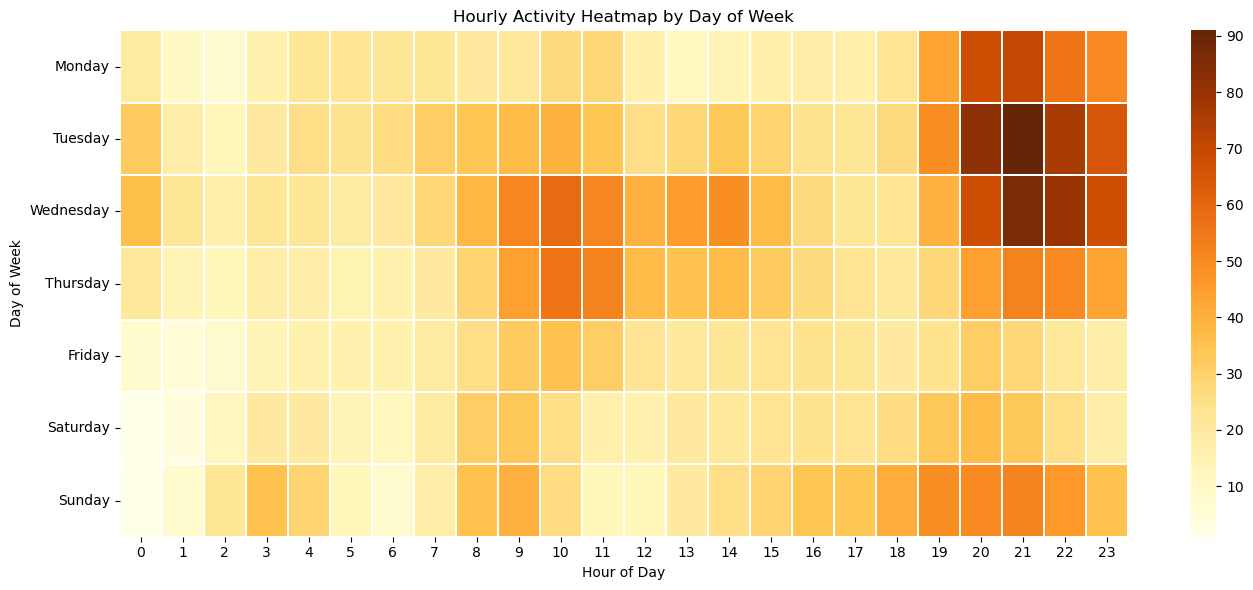

In [11]:

df['eventtime'] = pd.to_datetime(df['eventtime'])

# Extract hour and day of week
df['hour'] = df['eventtime'].dt.hour
df['day'] = df['eventtime'].dt.day_name()

# Create pivot table
heatmap_data = df.pivot_table(index='day', columns='hour', values='base_url', aggfunc='count', fill_value=0)

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Apply Gaussian filter
smoothed_data = gaussian_filter(heatmap_data, sigma=1)

# Plot smoothed heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(smoothed_data, cmap='YlOrBr', linewidths=0.3, xticklabels=range(24), yticklabels=day_order)
plt.title('Hourly Activity Heatmap by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

C:\Users\ravibh\AppData\Local\Temp\ipykernel_21600\2817355220.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




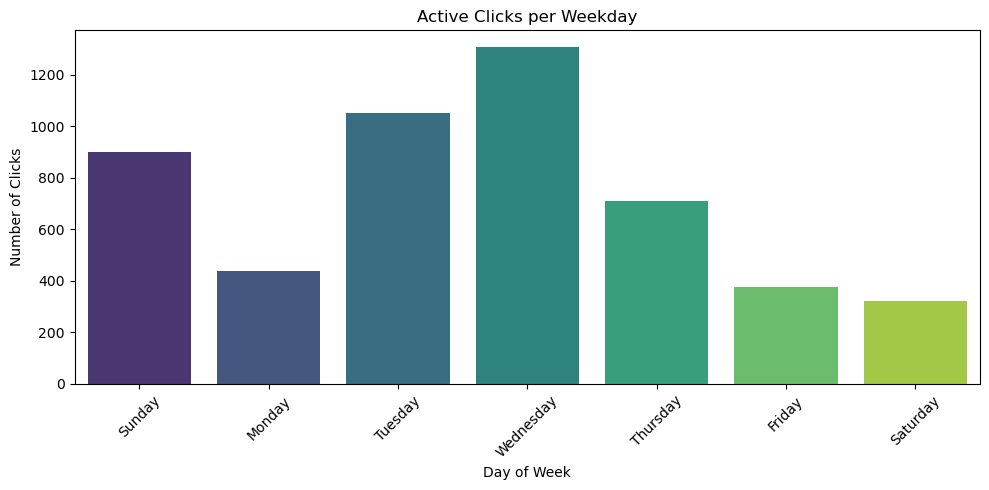

In [13]:
# Convert 'eventtime' to datetime
df['eventtime'] = pd.to_datetime(df['eventtime'])

# Extract weekday names
df['weekday'] = df['eventtime'].dt.day_name()

# Define correct weekday order
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Count events per weekday
weekday_counts = df['weekday'].value_counts().reindex(weekday_order, fill_value=0)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="viridis")
plt.title("Active Clicks per Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Number of Clicks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:

# Pie chart of the length of titles in each cluster
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Split top 10 and rest
top_10 = category_counts[:10]
other = category_counts[10:]

# Add 'Other' row
other_sum = other['count'].sum()
top_10_with_other = pd.concat([top_10, pd.DataFrame([{'category': 'Other', 'count': other_sum}])], ignore_index=True)

# Plot the pie chart
fig = px.pie(top_10_with_other, values='count', names='category', title='Website Categories Distribution (Top 10 + Other)',)
fig.update_traces(textinfo='percent+label')
fig.show()

In [70]:

# Group and count domain occurrences per category
grouped = df.groupby(['category', 'base_url']).size().reset_index(name='count')
categories = grouped['category'].unique()

for cat in categories:
    cat_data = grouped[grouped['category'] == cat].sort_values(by='count', ascending=False)

    # Top 10 + "Other"
    top10 = cat_data.head(10)
    others = cat_data.iloc[10:]

    if not others.empty:
        other_row = pd.DataFrame({
            'category': [cat],
            'base_url': ['Other'],
            'count': [others['count'].sum()]
        })
        pie_data = pd.concat([top10, other_row], ignore_index=True)
    else:
        pie_data = top10

    # Plotly Pie Chart with count and percentage
    fig = px.pie(
        pie_data,
        names='base_url',
        values='count',
        title=f'Domain Distribution in Category: {cat}',
        hole=0.7  # Optional: donut style
    )
    
    # Show both percentage and count
    fig.update_traces(textinfo='percent+label+value', texttemplate='%{label}: %{value} (%{percent:.1f}%)')
    
    # Show the figure
    fig.show()


## google and other search engin ana.


In [52]:
search_data = df[df['category'] == 'search_engine'].copy()
search_titles = search_data['title'].tolist()
embeddings = model.encode(search_titles, convert_to_tensor=True)

# Cluster with K-Means
kmeans = KMeans(n_clusters=32, random_state=42)
clusters = kmeans.fit_predict(embeddings.cpu().numpy())
# Display results
dfx = pd.DataFrame({"Title": search_titles, "Cluster": clusters})
dfx = dfx[dfx['Title'].notnull() & (dfx['Title'].str.strip() != '')]

# Group titles by cluster
grouped = dfx.groupby('Cluster')['Title'].apply(list).reset_index()

#  rotate the titles in each cluster
# This rotates (shifts) the list of titles by 1
grouped['Rotated Titles'] = grouped['Title'].apply(lambda x: x[1:] + x[:1] if len(x) > 1 else x)
# 3. Merge the titles into a single list per cluster
grouped['Merged Titles'] = grouped['Rotated Titles'].apply(lambda x: x)

# Final Result
print(grouped[['Cluster', 'Merged Titles']])
grouped = grouped.drop(columns=['Title'])
grouped = grouped.drop(columns=['Rotated Titles'])
#rename the column 'Merged Titles' to 'Titles'
grouped = grouped.rename(columns={'Merged Titles': 'Titles'})
grouped

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



    Cluster                                      Merged Titles
0         0  [Google Flights - Find Cheap Flight Options & ...
1         1  [Tokyo to Malaysia | Explore, Tokyo to Malaysi...
2         2  [Taipei City to San Francisco | Google Flights...
3         3  [Gmail, Sign in - Google Accounts, Sign in - G...
4         4  [companies house login - Google Search, acquir...
5         5  [Moment of Science: Hundreds of dinosaur footp...
6         6  [Shillong to Kolkata | Google Flights, San Fra...
7         7  [horse mat 1 inch thick - Google Shopping, hor...
8         8  [San Francisco to San José | Google Flights, S...
9         9  [livermore haircut school - Google Search, liv...
10       10  [Inner Space Cavern - Google Search, Inner Spa...
11       11  [how do i travel to meghalaya - Google Search,...
12       12  [android studio download mac - Google Search, ...
13       13  [can i get an mri in japan cost - Google Searc...
14       14  [Kochi to Tokyo | Google Flights, Tokyo to

,Cluster,Titles
0,0,[Google Flights - Find Cheap Flight Options & ...
1,1,"[Tokyo to Malaysia | Explore, Tokyo to Malaysi..."
2,2,[Taipei City to San Francisco | Google Flights...
3,3,"[Gmail, Sign in - Google Accounts, Sign in - G..."
4,4,"[companies house login - Google Search, acquir..."
5,5,[Moment of Science: Hundreds of dinosaur footp...
6,6,"[Shillong to Kolkata | Google Flights, San Fra..."
7,7,"[horse mat 1 inch thick - Google Shopping, hor..."
8,8,"[San Francisco to San José | Google Flights, S..."
9,9,"[livermore haircut school - Google Search, liv..."


In [ ]:
GENAI_API_KEY = "YOUR KEY HERE"
def search_filter(url):
    client = genai.Client(api_key=GENAI_API_KEY)
    #list to string
    url = ', '.join(url)

    response = client.models.generate_content(
    model="gemini-2.0-flash", contents=("Output category web search history  in single world puchese have some outliers ignor it , if all are outlier output other. eg-News, Shopping, Health, Education, Entertainment, Travel, Technology, Finance, Sports, Food & Recipes, Jobs & Careers, Local Services, DIY & How-To, Government & Legal, Social Media & Communication. History: " + url + " "),
)
    return response.text

In [ ]:
for i in range(len(grouped)):
    try:
        grouped.loc[i, 'category'] = search_filter(grouped.loc[i, 'Titles'])
        print(i)
    except Exception as e:
        print(f"Error generating category for {grouped.loc[i, 'Titles']}: {e}")
grouped

In [57]:
grouped

,Cluster,Titles,category,length
0,0,[Google Flights - Find Cheap Flight Options & ...,Travel\n,7
1,1,"[Tokyo to Malaysia | Explore, Tokyo to Malaysi...",Travel\n,7
2,2,[Taipei City to San Francisco | Google Flights...,Travel\n,7
3,3,"[Gmail, Sign in - Google Accounts, Sign in - G...",Social Media & Communication\n,29
4,4,"[companies house login - Google Search, acquir...",Jobs & Careers\n,15
5,5,[Moment of Science: Hundreds of dinosaur footp...,Travel\n,7
6,6,"[Shillong to Kolkata | Google Flights, San Fra...",Travel\n,7
7,7,"[horse mat 1 inch thick - Google Shopping, hor...",Shopping\n,9
8,8,"[San Francisco to San José | Google Flights, S...",Travel\n,7
9,9,"[livermore haircut school - Google Search, liv...",Travel\n,7


In [58]:
#length of titles in each cluster save it in new column 'length'
grouped['length'] = grouped['category'].apply(lambda x: len(x))
# Pie chart of the length of titles in each cluster
fig = px.pie(grouped, values='length', names='category', title='Google Search History')
fig.update_traces(textinfo='percent+label')
fig.show()

In [40]:


def calculate_daily_active_time(df, category_filter='social_media', max_daily_hours=24):
    """
    Calculate daily active time with perfect 24-hour compliance
    using session-based time allocation
    """
    # Filter data
    filtered_df = df[df['category'] == category_filter].copy()
    if filtered_df.empty:
        print(f"No data found for category: {category_filter}")
        return None

    # Sort by timestamp
    filtered_df = filtered_df.sort_values('eventtimeutc')
    
    # Create sessions (5-minute gap threshold)
    filtered_df['time_diff'] = filtered_df['eventtimeutc'].diff().fillna(pd.Timedelta(0))
    session_gap = pd.Timedelta(minutes=5)
    filtered_df['session_id'] = (filtered_df['time_diff'] > session_gap).cumsum()

    # Get session time ranges
    sessions = filtered_df.groupby('session_id')['eventtimeutc'].agg(['min', 'max'])
    sessions.columns = ['start_time', 'end_time']
    sessions['duration'] = sessions['end_time'] - sessions['start_time']

    # Calculate daily active time
    daily_usage = {}
    for _, session in sessions.iterrows():
        current_date = session['start_time'].date()
        end_date = session['end_time'].date()
        
        while current_date <= end_date:
            # Get date boundaries in UTC
            day_start = pd.Timestamp(current_date).tz_localize('UTC')
            day_end = day_start + timedelta(days=1)
            
            # Calculate overlap between session and day
            overlap_start = max(session['start_time'], day_start)
            overlap_end = min(session['end_time'], day_end)
            active_time = max(pd.Timedelta(0), overlap_end - overlap_start)
            
            # Add to daily total
            hours = active_time.total_seconds() / 3600
            daily_usage[current_date] = daily_usage.get(current_date, 0) + hours
            current_date += timedelta(days=1)

    # Cap at max daily hours and create DataFrame
    daily_df = pd.DataFrame({
        'date': [pd.Timestamp(d) for d in daily_usage.keys()],
        'active_hours': [min(h, max_daily_hours) for h in daily_usage.values()]
    }).sort_values('date')

    # Add weekday information
    daily_df['weekday'] = daily_df['date'].dt.strftime('%a')
    weekday_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    daily_df['weekday'] = pd.Categorical(daily_df['weekday'], categories=weekday_order, ordered=True)

    return daily_df

def analyze_and_visualize(df, category='social_media'):
    # Calculate daily active time
    daily_usage = calculate_daily_active_time(df, category)
    
    if daily_usage is None:
        return
    
    # Create visualizations
    fig = px.line(daily_usage, 
                 x='date', y='active_hours',
                 title=f'Daily {category.title()} Usage',
                 labels={'active_hours': 'Active Hours', 'date': 'Date'})
    

    
    fig.show()
    


# Run analysis
analyze_and_visualize(df, 'social_media')

In [74]:
def analyze_sociamedia_activity(df):
    # Filter socia media data
    social_df = df[df['category'] == 'social_media'].copy()
    
    # 1. Basic Stats
    print(f"Total socia media visits: {len(social_df)}")
    print(f"Unique socia media domains: {social_df['base_url'].nunique()}")
    print(f"Time range: {social_df['eventtimeutc'].min()} to {social_df['eventtimeutc'].max()}")

    # 2. Temporal Analysis
    # Hourly pattern
    social_df['hour'] = social_df['eventtimeutc'].dt.hour
    hourly = social_df.groupby('hour').size().reset_index(name='visits')
    
    fig = px.bar(hourly, x='hour', y='visits', 
                 title='socia media Activity by Hour',
                 labels={'hour': 'Hour of Day (UTC)', 'visits': 'Visits'})
    fig.update_layout(xaxis=dict(tickmode='linear', dtick=1))
    fig.show()

    # Daily pattern
    social_df['day_of_week'] = social_df['eventtimeutc'].dt.day_name()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily = social_df.groupby('day_of_week').size().reindex(weekday_order).reset_index(name='visits')
    
    fig = px.bar(daily, x='day_of_week', y='visits',
                 title='socia media Activity by Day of Week',
                 labels={'day_of_week': 'Day', 'visits': 'Visits'})
    fig.show()

    # 3. Domain Analysis
    domain_stats = social_df['base_url'].value_counts().head(10).reset_index()
    domain_stats.columns = ['base_url', 'visits']
    
    fig = px.bar(domain_stats, x='base_url', y='visits',
                 title='Top 10 socia media Domains',
                 labels={'base_url': 'base_url', 'visits': 'Visits'})
    fig.show()



    # 5. Session Analysis (within socia media category)
    social_df = social_df.sort_values('eventtimeutc')
    social_df['time_diff'] = social_df['eventtimeutc'].diff().fillna(pd.Timedelta(0))
    social_df['session_id'] = (social_df['time_diff'] > pd.Timedelta(minutes=5)).cumsum()
    
    sessions = social_df.groupby('session_id').agg(
        duration=('eventtimeutc', lambda x: (x.max() - x.min()).total_seconds() / 60),
        page_views=('url', 'count')
    ).reset_index()
    
    print("\nSession Statistics:")
    print(f"Median session duration: {sessions['duration'].median():.1f} minutes")
    print(f"Average pages per session: {sessions['page_views'].mean():.1f}")
    
    return social_df, sessions

# Run analysis
ecom_data, session_stats = analyze_sociamedia_activity(df)

Total socia media visits: 183
Unique socia media domains: 8
Time range: 2025-01-22 01:58:54.073000+00:00 to 2025-02-19 22:21:54.126000+00:00



Session Statistics:
Median session duration: 0.1 minutes
Average pages per session: 5.9


In [41]:
def analyze_ecommerce_activity(df):
    # Filter e-commerce data
    ecom_df = df[df['category'] == 'e_commerce'].copy()
    
    # 1. Basic Stats
    print(f"Total e-commerce visits: {len(ecom_df)}")
    print(f"Unique e-commerce domains: {ecom_df['base_url'].nunique()}")
    print(f"Time range: {ecom_df['eventtimeutc'].min()} to {ecom_df['eventtimeutc'].max()}")

    # 2. Temporal Analysis
    # Hourly pattern
    ecom_df['hour'] = ecom_df['eventtimeutc'].dt.hour
    hourly = ecom_df.groupby('hour').size().reset_index(name='visits')
    
    fig = px.bar(hourly, x='hour', y='visits', 
                 title='E-commerce Activity by Hour',
                 labels={'hour': 'Hour of Day (UTC)', 'visits': 'Visits'})
    fig.update_layout(xaxis=dict(tickmode='linear', dtick=1))
    fig.show()

    # Daily pattern
    ecom_df['day_of_week'] = ecom_df['eventtimeutc'].dt.day_name()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily = ecom_df.groupby('day_of_week').size().reindex(weekday_order).reset_index(name='visits')
    
    fig = px.bar(daily, x='day_of_week', y='visits',
                 title='E-commerce Activity by Day of Week',
                 labels={'day_of_week': 'Day', 'visits': 'Visits'})
    fig.show()

    # 3. Domain Analysis
    domain_stats = ecom_df['base_url'].value_counts().head(10).reset_index()
    domain_stats.columns = ['base_url', 'visits']
    
    fig = px.bar(domain_stats, x='base_url', y='visits',
                 title='Top 10 E-commerce Domains',
                 labels={'base_url': 'base_url', 'visits': 'Visits'})
    fig.show()

    # 4. Transition Type Analysis
    transition_stats = ecom_df['transition'].value_counts().reset_index()
    transition_stats.columns = ['transition_type', 'count']
    
    fig = px.pie(transition_stats, names='transition_type', values='count',
                 title='Entry Methods to E-commerce Sites')
    fig.show()

    # 5. Session Analysis (within e-commerce category)
    ecom_df = ecom_df.sort_values('eventtimeutc')
    ecom_df['time_diff'] = ecom_df['eventtimeutc'].diff().fillna(pd.Timedelta(0))
    ecom_df['session_id'] = (ecom_df['time_diff'] > pd.Timedelta(minutes=5)).cumsum()
    
    sessions = ecom_df.groupby('session_id').agg(
        duration=('eventtimeutc', lambda x: (x.max() - x.min()).total_seconds() / 60),
        page_views=('url', 'count')
    ).reset_index()
    
    print("\nSession Statistics:")
    print(f"Median session duration: {sessions['duration'].median():.1f} minutes")
    print(f"Average pages per session: {sessions['page_views'].mean():.1f}")
    
    return ecom_df, sessions

# Run analysis
ecom_data, session_stats = analyze_ecommerce_activity(df)

Total e-commerce visits: 547
Unique e-commerce domains: 95
Time range: 2025-01-21 16:55:17.128000+00:00 to 2025-02-21 05:47:44.822000+00:00



Session Statistics:
Median session duration: 0.0 minutes
Average pages per session: 4.5


In [42]:
ecom_df = df[df['category'] == 'e_commerce'].copy()
top_domains = ecom_df['base_url'].value_counts().head(10)
print("Top E-Commerce Sites:")
print(top_domains)

Top E-Commerce Sites:
base_url
www.amazon.in             123
www.tractorsupply.com      33
www.homedepot.com          32
htmltemplates.co           17
www.flipkart.com           17
www.amazon.com             17
silmedspa.com              14
client.ipostalmail.net     13
quickpay.hmshost.com       13
www.target.com             13
Name: count, dtype: int64


In [43]:
titles = ecom_df['title'].tolist()
#unique titles
unique_titles = ecom_df['title'].unique()
#length of unique titles
len(unique_titles)

217

In [44]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(unique_titles, convert_to_tensor=True)

# Cluster with K-Means
kmeans = KMeans(n_clusters=17, random_state=42)
clusters = kmeans.fit_predict(embeddings.cpu().numpy())

# Display results
dfx = pd.DataFrame({"Title": unique_titles, "Cluster": clusters})
# Filter out empty or invalid titles
dfx = dfx[dfx['Title'].notnull() & (dfx['Title'].str.strip() != '')]

# Group titles by cluster
grouped = dfx.groupby('Cluster')['Title'].apply(list).reset_index()

#  rotate the titles in each cluster
# This rotates (shifts) the list of titles by 1
grouped['Rotated Titles'] = grouped['Title'].apply(lambda x: x[1:] + x[:1] if len(x) > 1 else x)
# 3. Merge the titles into a single list per cluster
grouped['Merged Titles'] = grouped['Rotated Titles'].apply(lambda x: x)

# Final Result
print(grouped[['Cluster', 'Merged Titles']])

    Cluster                                      Merged Titles
0         0                       [Clutter | Moving & Storage]
1         1  [British Gas, Shopping Cart | Tractor Supply C...
2         2  [Valentine &#39; s Day Gifts for Dogs & Cats |...
3         3  [Murphy Beds — Sacramento Furniture Store, Dri...
4         4  [1 inch Horse Stall Tiles - Equine Floor Mats,...
5         5  [Amazon.in : jungle leaf fondant butter, Amazo...
6         6  [Buy RKPM HOMES 4 Pieces Tropical Leaf Cookie ...
7         7  [We’re Behaviorally. Guided with Decision Prec...
8         8  [Prime Video | Watch movies &#44;  TV shows &#...
9         9  [California Pizza Kitchen - Quickpay, Persiste...
10       10  [Search results | DublinRecGuide, Resource det...
11       11  [ISDIN Pediatrics Fusion Water SPF 50 50ml | F...
12       12  [TriValley Ice Field Trip, Zero Gravity - Expe...
13       13  [Thomsoon portfolio - Free Minimalist Responsi...
14       14  [YOULY | Petco, Will You See Dolphins on a

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [ ]:
grouped = grouped.drop(columns=['Title'])
grouped = grouped.drop(columns=['Rotated Titles'])
#rename the column 'Merged Titles' to 'Titles'
grouped = grouped.rename(columns={'Merged Titles': 'Titles'})

#replace with your google api key

GENAI_API_KEY = "YOUR KEY"
from google import genai
def generate(url):
    client = genai.Client(api_key=GENAI_API_KEY)
    #list to string
    url = ', '.join(url)

    response = client.models.generate_content(
    model="gemini-2.0-flash", contents=("Output category of puchese of items in single world puchese have some outliers ignor it , if all are outlier output other. eg-Electronics, Fashion, Home & Kitchen, Health & Beauty, Sports & Outdoors, Books & Stationery, puchese: " + url + " "),
)
    return response.text
# set tpye of cluster using the function generate send titles as string not list
for i in range(len(grouped)):
    try:
        grouped.loc[i, 'category'] = generate(grouped.loc[i, 'Titles'])
        print(i)
    except Exception as e:
        print(f"Error generating category for {grouped.loc[i, 'Titles']}: {e}")

In [46]:
#length of titles in each cluster save it in new column 'length'
grouped['length'] = grouped['Titles'].apply(lambda x: len(x))
#remove rows of Others
grouped = grouped[grouped['category'] != 'Other\n']

In [47]:
# Exclude the "other" category
filtered_grouped = grouped[grouped['category'] != 'Other']

# Pie chart of the length of titles in each cluster
fig = px.pie(filtered_grouped, values='length', names='category', title='Purchase Categories Distribution (Top 10 + Other)',)
fig.update_traces(textinfo='percent+label')
fig.show()